# Data Processing

## Data Acquisition

We are going to use dataset from kaggle with this link: https://www.kaggle.com/datasets/ritupande/fire-detection-from-cctv/data

In [1]:
# ✅ Standard Library
import os
import random
import shutil
from pathlib import Path

# ✅ External Tools
import kagglehub
from tqdm import tqdm
from PIL import Image
from IPython.display import display

# ✅ Scientific Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ PyTorch Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# ✅ Torch Vision / Augmentation
from torchvision.io import read_image
from torchvision.transforms import (
    Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
)
import torchvision.transforms.functional as F

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/home/lee/miniconda3/envs/fire-detection/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
data_path = Path("../")  # more descriptive than ".."
data_path.mkdir(parents=True, exist_ok=True)

# Download dataset using kagglehub
download_path = Path(kagglehub.dataset_download("ritupande/fire-detection-from-cctv"))

# Move all contents from download_path to your custom data_path
for item in download_path.iterdir():
    target = data_path / item.name
    if item.is_dir():
        shutil.copytree(item, target, dirs_exist_ok=True)
    else:
        shutil.copy2(item, target)

print("Dataset moved to:", data_path.resolve())


In [ ]:
path = '../data/img_data/train/fire'

image_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image = random.choice(image_files)



img = Image.open(os.path.join(path, random_image))
display(img)
print("Displayed:", random_image)

## Turn loaded images into DataLoader

In [47]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
train_dir = "../data/img_data/train"
test_dir = "../data/img_data/test"
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = ImageFolder(root=train_dir, transform=transform)
  test_data = ImageFolder(root=test_dir, transform=transform)
  
  # Get classname
  class_names = train_data.classes
  
  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

## Customize a pretrained model

We testing with resnet model, cnn model,...

In [48]:
import torchvision
weights = torchvision.models.ResNet101_Weights.DEFAULT
model = torchvision.models.resnet101(weights=weights).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [51]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=preprocess,
                                                       batch_size=32,
                                                       num_workers=NUM_WORKERS)

In [52]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x766f85c19670>,
 ['default', 'fire', 'smoke'])

In [53]:
from torchinfo import summary
summary(model, 
        input_size=(32,3,224,224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [54]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [56]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)

# Replace the classifier head (usually for 2 classes: fire vs. no fire)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, 3)  # 2 classes
)

In [57]:
# Check trainable layers
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")


Trainable parameters: 525,315


In [58]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [59]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)




In [61]:
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    
    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()
  
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = y_pred.argmax(dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 
  
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
  
          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          
  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      scheduler.step(test_loss)
  # Return the filled results at the end of the epochs
  return results

In [62]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       scheduler = scheduler,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:02<02:15,  2.76s/it]

Epoch: 1 | train_loss: 0.6335 | train_acc: 0.7819 | test_loss: 0.6642 | test_acc: 0.7064


  4%|▍         | 2/50 [00:05<02:11,  2.73s/it]

Epoch: 2 | train_loss: 0.2210 | train_acc: 0.9197 | test_loss: 0.7658 | test_acc: 0.6813


  6%|▌         | 3/50 [00:08<02:07,  2.72s/it]

Epoch: 3 | train_loss: 0.1353 | train_acc: 0.9574 | test_loss: 0.9162 | test_acc: 0.6709


  8%|▊         | 4/50 [00:10<02:03,  2.70s/it]

Epoch: 4 | train_loss: 0.0964 | train_acc: 0.9631 | test_loss: 1.2605 | test_acc: 0.6813


 10%|█         | 5/50 [00:13<02:00,  2.69s/it]

Epoch: 5 | train_loss: 0.0792 | train_acc: 0.9759 | test_loss: 1.3659 | test_acc: 0.6761


 12%|█▏        | 6/50 [00:16<01:58,  2.69s/it]

Epoch: 6 | train_loss: 0.0571 | train_acc: 0.9858 | test_loss: 1.1861 | test_acc: 0.6605


 14%|█▍        | 7/50 [00:18<01:56,  2.71s/it]

Epoch: 7 | train_loss: 0.0509 | train_acc: 0.9836 | test_loss: 1.1135 | test_acc: 0.6657


 16%|█▌        | 8/50 [00:21<01:53,  2.70s/it]

Epoch: 8 | train_loss: 0.0597 | train_acc: 0.9773 | test_loss: 1.1225 | test_acc: 0.6657


 18%|█▊        | 9/50 [00:24<01:50,  2.70s/it]

Epoch: 9 | train_loss: 0.0455 | train_acc: 0.9886 | test_loss: 1.1108 | test_acc: 0.6605


 20%|██        | 10/50 [00:27<01:47,  2.70s/it]

Epoch: 10 | train_loss: 0.0543 | train_acc: 0.9794 | test_loss: 1.1690 | test_acc: 0.6657


 22%|██▏       | 11/50 [00:29<01:45,  2.71s/it]

Epoch: 11 | train_loss: 0.0538 | train_acc: 0.9865 | test_loss: 1.1257 | test_acc: 0.6605


 24%|██▍       | 12/50 [00:32<01:42,  2.69s/it]

Epoch: 12 | train_loss: 0.0471 | train_acc: 0.9872 | test_loss: 1.1248 | test_acc: 0.6605


 26%|██▌       | 13/50 [00:35<01:39,  2.70s/it]

Epoch: 13 | train_loss: 0.0511 | train_acc: 0.9879 | test_loss: 1.0922 | test_acc: 0.6605


 28%|██▊       | 14/50 [00:37<01:36,  2.68s/it]

Epoch: 14 | train_loss: 0.0363 | train_acc: 0.9943 | test_loss: 1.1103 | test_acc: 0.6709


 30%|███       | 15/50 [00:40<01:33,  2.67s/it]

Epoch: 15 | train_loss: 0.0429 | train_acc: 0.9872 | test_loss: 1.1374 | test_acc: 0.6605


 32%|███▏      | 16/50 [00:43<01:31,  2.68s/it]

Epoch: 16 | train_loss: 0.0454 | train_acc: 0.9872 | test_loss: 1.1491 | test_acc: 0.6553


 34%|███▍      | 17/50 [00:45<01:27,  2.67s/it]

Epoch: 17 | train_loss: 0.0447 | train_acc: 0.9858 | test_loss: 1.1057 | test_acc: 0.6605


 36%|███▌      | 18/50 [00:48<01:24,  2.64s/it]

Epoch: 18 | train_loss: 0.0559 | train_acc: 0.9801 | test_loss: 1.0894 | test_acc: 0.6657


 38%|███▊      | 19/50 [00:50<01:21,  2.62s/it]

Epoch: 19 | train_loss: 0.0428 | train_acc: 0.9871 | test_loss: 1.1694 | test_acc: 0.6657


 40%|████      | 20/50 [00:53<01:17,  2.59s/it]

Epoch: 20 | train_loss: 0.0475 | train_acc: 0.9858 | test_loss: 1.1653 | test_acc: 0.6605


 42%|████▏     | 21/50 [00:55<01:14,  2.57s/it]

Epoch: 21 | train_loss: 0.0506 | train_acc: 0.9872 | test_loss: 1.1499 | test_acc: 0.6605


 44%|████▍     | 22/50 [00:58<01:11,  2.55s/it]

Epoch: 22 | train_loss: 0.0466 | train_acc: 0.9851 | test_loss: 1.1289 | test_acc: 0.6657


 46%|████▌     | 23/50 [01:00<01:08,  2.54s/it]

Epoch: 23 | train_loss: 0.0485 | train_acc: 0.9851 | test_loss: 1.1426 | test_acc: 0.6605


 48%|████▊     | 24/50 [01:03<01:06,  2.54s/it]

Epoch: 24 | train_loss: 0.0468 | train_acc: 0.9858 | test_loss: 1.1529 | test_acc: 0.6657


 50%|█████     | 25/50 [01:06<01:03,  2.55s/it]

Epoch: 25 | train_loss: 0.0608 | train_acc: 0.9830 | test_loss: 1.1582 | test_acc: 0.6657


 52%|█████▏    | 26/50 [01:08<01:01,  2.56s/it]

Epoch: 26 | train_loss: 0.0505 | train_acc: 0.9901 | test_loss: 1.1750 | test_acc: 0.6605


 54%|█████▍    | 27/50 [01:11<00:58,  2.55s/it]

Epoch: 27 | train_loss: 0.0455 | train_acc: 0.9893 | test_loss: 1.1311 | test_acc: 0.6605


 56%|█████▌    | 28/50 [01:13<00:55,  2.54s/it]

Epoch: 28 | train_loss: 0.0471 | train_acc: 0.9886 | test_loss: 1.1367 | test_acc: 0.6605


 58%|█████▊    | 29/50 [01:16<00:53,  2.57s/it]

Epoch: 29 | train_loss: 0.0450 | train_acc: 0.9907 | test_loss: 1.1333 | test_acc: 0.6657


 60%|██████    | 30/50 [01:19<00:52,  2.62s/it]

Epoch: 30 | train_loss: 0.0490 | train_acc: 0.9872 | test_loss: 1.2097 | test_acc: 0.6657


 62%|██████▏   | 31/50 [01:21<00:50,  2.64s/it]

Epoch: 31 | train_loss: 0.0599 | train_acc: 0.9801 | test_loss: 1.1508 | test_acc: 0.6657


 64%|██████▍   | 32/50 [01:24<00:48,  2.68s/it]

Epoch: 32 | train_loss: 0.0450 | train_acc: 0.9915 | test_loss: 1.1160 | test_acc: 0.6605


 66%|██████▌   | 33/50 [01:27<00:45,  2.70s/it]

Epoch: 33 | train_loss: 0.0445 | train_acc: 0.9893 | test_loss: 1.1628 | test_acc: 0.6657


 68%|██████▊   | 34/50 [01:30<00:43,  2.71s/it]

Epoch: 34 | train_loss: 0.0452 | train_acc: 0.9858 | test_loss: 1.1422 | test_acc: 0.6657


 70%|███████   | 35/50 [01:32<00:40,  2.71s/it]

Epoch: 35 | train_loss: 0.0417 | train_acc: 0.9901 | test_loss: 1.1630 | test_acc: 0.6657


 72%|███████▏  | 36/50 [01:35<00:37,  2.70s/it]

Epoch: 36 | train_loss: 0.0442 | train_acc: 0.9872 | test_loss: 1.1719 | test_acc: 0.6657


 74%|███████▍  | 37/50 [01:38<00:34,  2.68s/it]

Epoch: 37 | train_loss: 0.0467 | train_acc: 0.9893 | test_loss: 1.1480 | test_acc: 0.6605


 76%|███████▌  | 38/50 [01:40<00:32,  2.70s/it]

Epoch: 38 | train_loss: 0.0413 | train_acc: 0.9929 | test_loss: 1.1557 | test_acc: 0.6605


 78%|███████▊  | 39/50 [01:43<00:29,  2.67s/it]

Epoch: 39 | train_loss: 0.0594 | train_acc: 0.9794 | test_loss: 1.1109 | test_acc: 0.6657


 80%|████████  | 40/50 [01:45<00:26,  2.63s/it]

Epoch: 40 | train_loss: 0.0553 | train_acc: 0.9822 | test_loss: 1.1280 | test_acc: 0.6657


 82%|████████▏ | 41/50 [01:48<00:23,  2.60s/it]

Epoch: 41 | train_loss: 0.0471 | train_acc: 0.9871 | test_loss: 1.1199 | test_acc: 0.6553


 84%|████████▍ | 42/50 [01:50<00:20,  2.59s/it]

Epoch: 42 | train_loss: 0.0523 | train_acc: 0.9851 | test_loss: 1.1599 | test_acc: 0.6605


 86%|████████▌ | 43/50 [01:53<00:17,  2.57s/it]

Epoch: 43 | train_loss: 0.0461 | train_acc: 0.9886 | test_loss: 1.1378 | test_acc: 0.6657


 88%|████████▊ | 44/50 [01:56<00:15,  2.59s/it]

Epoch: 44 | train_loss: 0.0566 | train_acc: 0.9865 | test_loss: 1.1275 | test_acc: 0.6605


 90%|█████████ | 45/50 [01:58<00:12,  2.57s/it]

Epoch: 45 | train_loss: 0.0554 | train_acc: 0.9773 | test_loss: 1.1491 | test_acc: 0.6657


 92%|█████████▏| 46/50 [02:01<00:10,  2.54s/it]

Epoch: 46 | train_loss: 0.0418 | train_acc: 0.9915 | test_loss: 1.1809 | test_acc: 0.6605


 94%|█████████▍| 47/50 [02:03<00:07,  2.53s/it]

Epoch: 47 | train_loss: 0.0522 | train_acc: 0.9801 | test_loss: 1.1194 | test_acc: 0.6605


 96%|█████████▌| 48/50 [02:06<00:05,  2.52s/it]

Epoch: 48 | train_loss: 0.0487 | train_acc: 0.9801 | test_loss: 1.1132 | test_acc: 0.6501


 98%|█████████▊| 49/50 [02:08<00:02,  2.54s/it]

Epoch: 49 | train_loss: 0.0465 | train_acc: 0.9886 | test_loss: 1.1413 | test_acc: 0.6605


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]

Epoch: 50 | train_loss: 0.0542 | train_acc: 0.9822 | test_loss: 1.1805 | test_acc: 0.6657
[INFO] Total training time: 131.394 seconds


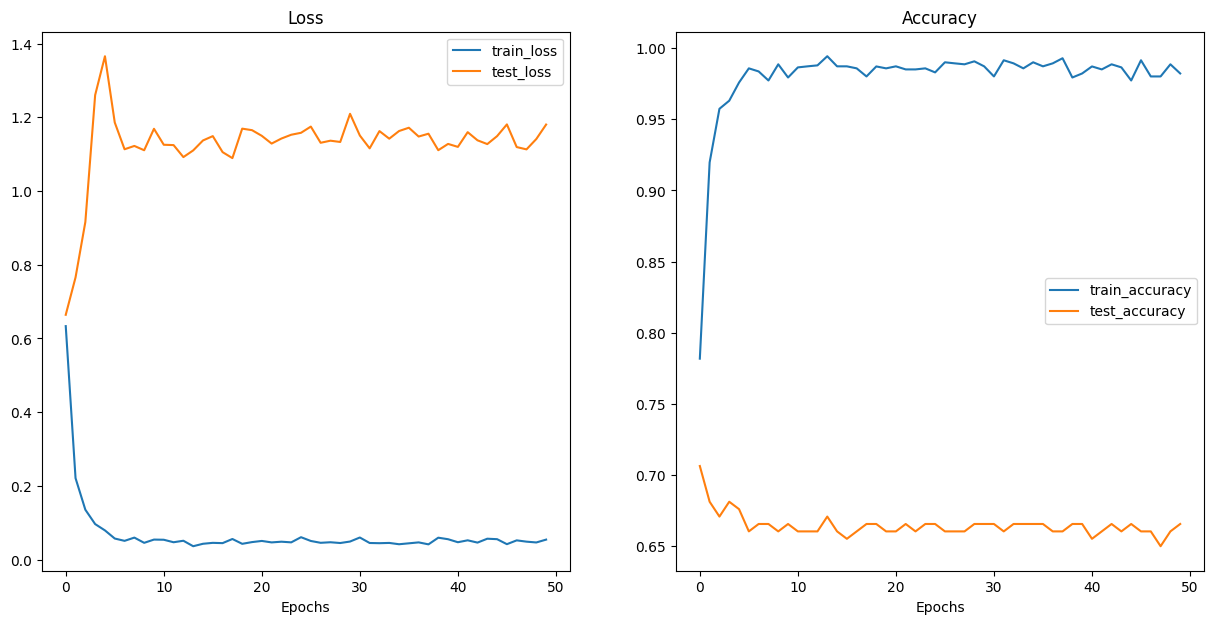

In [63]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [30]:
# Example test_transform from earlier
test_transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load image
img_path = '../data/img_data/test/fire/img_241.jpg'  # update this path
image = Image.open(img_path).convert("RGB")
input_tensor = test_transform(image).unsqueeze(0)  # shape: [1, 3, 224, 224]


In [31]:
import torch.nn.functional as F  # ✅ This is correct for softmax

model.eval()
input_tensor = input_tensor.to(device)

with torch.inference_mode():
    logits = model(input_tensor)  # shape: [1, num_classes]
    probs = F.softmax(logits, dim=1)  # Convert to class probabilities
    pred_idx = torch.argmax(probs, dim=1).item()
    
print(f"Predicted class: {class_names[pred_idx]}")
print("Class probabilities:")
for i, prob in enumerate(probs[0]):
    print(f"{class_names[i]}: {prob.item():.4f}")


Predicted class: default
Class probabilities:
default: 0.7706
fire: 0.0455
smoke: 0.1840


Make simple CNN